
# CAPTCHA Generator: Classical Compositor + Conditional DCGAN

This notebook accepts a **string** and outputs a **CAPTCHA image** using two methods:
1) **Classical**: sample segmented character assets + augment + compose.
2) **cGAN**: train a conditional DCGAN to generate character sprites, then compose.

**Expected data structure** (confirmed):
```
chars_by_class/
 ├── 0/
 ├── 1/
 ├── 2/
 ├── ...
 ├── a/
 │   ├── A_cap/
 │   └── a_small/
 ├── b/
 │   ├── B_cap/
 │   └── b_small/
 ├── j/        # no cap/small subfolders if visually identical
 └── ...
```


## 1. Setup & Imports

In [13]:

# %pip install torch torchvision opencv-python pillow matplotlib tqdm

import os, random, string
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFilter
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


## 2. Scan Dataset & Build Token Map

In [14]:
DATA_ROOT = Path("data\chars_by_class")  # main root

DIGITS_DIR = DATA_ROOT / "digits"
LETTERS_DIR = DATA_ROOT / "letters"

def scan_dataset(root: Path):
    assets: Dict[str, List[Path]] = {}
    token_meta: Dict[str, dict] = {}

    # ----- Digits -----
    for ddir in (DIGITS_DIR.iterdir() if DIGITS_DIR.exists() else []):
        if ddir.is_dir():
            d = ddir.name
            paths = [p for p in ddir.rglob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]
            if paths:
                assets[d] = paths
                token_meta[d] = {"kind": "digit", "char": d, "source": str(ddir)}

    # ----- Letters -----
    for ldir in (LETTERS_DIR.iterdir() if LETTERS_DIR.exists() else []):
        if not ldir.is_dir():
            continue
        ch = ldir.name
        cap_dir = ldir / f"{ch.upper()}_cap"
        small_dir = ldir / f"{ch}_small"
        files_direct = [p for p in ldir.glob("*") if p.is_file() and p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]

        if cap_dir.is_dir() and small_dir.is_dir():
            cap_paths = [p for p in cap_dir.rglob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]
            sm_paths  = [p for p in small_dir.rglob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}]
            if cap_paths:
                token = f"{ch.upper()}_cap"
                assets[token] = cap_paths
                token_meta[token] = {"kind":"letter_case","char":ch,"case":"cap","source":str(cap_dir)}
            if sm_paths:
                token = f"{ch}_small"
                assets[token] = sm_paths
                token_meta[token] = {"kind":"letter_case","char":ch,"case":"small","source":str(small_dir)}
        else:
            if files_direct:
                token = ch
                assets[token] = files_direct
                token_meta[token] = {"kind":"letter_single","char":ch,"source":str(ldir)}

    # ----- Mapping -----
    idx_to_token = sorted(assets.keys())
    token_to_idx = {t: i for i, t in enumerate(idx_to_token)}

    print(f"Found {len(idx_to_token)} tokens/classes.")
    for t in idx_to_token[:20]:
        print(" ", t, "->", len(assets[t]), "images")
    if len(idx_to_token) > 20:
        print(" ...")
    return assets, token_meta, token_to_idx, idx_to_token

ASSETS, TOKEN_META, TOKEN_TO_IDX, IDX_TO_TOKEN = scan_dataset(DATA_ROOT)


Found 54 tokens/classes.
  0 -> 1301 images
  1 -> 1333 images
  2 -> 1237 images
  3 -> 1335 images
  4 -> 1300 images
  5 -> 1262 images
  6 -> 1297 images
  7 -> 1253 images
  8 -> 1271 images
  9 -> 1292 images
  A_cap -> 577 images
  B_cap -> 659 images
  C_cap -> 1175 images
  D_cap -> 587 images
  E_cap -> 537 images
  F_cap -> 610 images
  G_cap -> 593 images
  H_cap -> 592 images
  I_cap -> 863 images
  L_cap -> 289 images
 ...


## 3. Utils: Image I/O & Viz

In [15]:

def load_rgba(path: Path) -> Image.Image:
    return Image.open(path).convert("RGBA")

def show_image(im: Image.Image, title=None, size=None):
    plt.figure()
    if size: im = im.resize(size, Image.NEAREST)
    plt.imshow(im)
    if title: plt.title(title)
    plt.axis("off")
    plt.show()

def pick_token_for_char(ch: str) -> str:
    if ch.isdigit():
        if ch in ASSETS: return ch
        raise KeyError(f"No assets for digit {ch}")
    if ch.isalpha():
        l = ch.lower()
        cap = f"{l.upper()}_cap"
        small = f"{l}_small"
        if ch.isupper():
            if cap in ASSETS: return cap
            if l in ASSETS: return l
            if small in ASSETS: return small
        else:
            if small in ASSETS: return small
            if l in ASSETS: return l
            if cap in ASSETS: return cap
    raise KeyError(f"No asset token for '{ch}'")


## 4. Classical Compositional Generator

In [16]:
def add_padding(im: Image.Image, pad_x_ratio=0.25, pad_y_ratio=0.05, color=(255,255,255,255)):
    """
    Add horizontal/vertical padding around a character image.
    pad_x_ratio: fraction of width to pad each side (0.25 → 25% left/right)
    pad_y_ratio: fraction of height to pad each side (0.05 → 5% top/bottom)
    color: background fill (white with full alpha)
    """
    w, h = im.size
    px, py = int(w * pad_x_ratio), int(h * pad_y_ratio)
    new_w, new_h = w + 2 * px, h + 2 * py
    new_img = Image.new("RGBA", (new_w, new_h), color)
    new_img.paste(im, (px, py))
    return new_img

In [17]:

def sample_char_image(token: str) -> Image.Image:
    p = random.choice(ASSETS[token])
    return load_rgba(p)

def random_rotation(im: Image.Image, max_deg=0):
    ang = random.uniform(-max_deg, max_deg)
    return im.rotate(ang, resample=Image.BICUBIC, expand=True)

def random_perspective(im: Image.Image, max_warp=0.12):
    # Simple affine approximation using PIL's transform with QUAD mapping
    w, h = im.size
    dx = int(w*max_warp)
    dy = int(h*max_warp)
    src = (0,0, w,0, w,h, 0,h)
    dst = (
        random.randint(-dx, dx), random.randint(-dy, dy),
        w+random.randint(-dx, dx), random.randint(-dy, dy),
        w+random.randint(-dx, dx), h+random.randint(-dy, dy),
        random.randint(-dx, dx),   h+random.randint(-dy, dy)
    )
    return im.transform((w,h), Image.QUAD, dst, resample=Image.BICUBIC)

def random_blur(im: Image.Image, p=0.35):
    if random.random()<p:
        return im.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3,1.2)))
    return im

def add_occlusions(im: Image.Image, p_line=0.6, p_dots=0.5):
    im = im.copy()
    draw = ImageDraw.Draw(im)
    w,h = im.size
    if random.random()<p_line:
        for _ in range(random.randint(1,3)):
            x1,y1 = random.randint(0,w),random.randint(0,h)
            x2,y2 = random.randint(0,w),random.randint(0,h)
            col = (random.randint(0,180),random.randint(0,180),random.randint(0,180),random.randint(90,170))
            draw.line((x1,y1,x2,y2), fill=col, width=random.randint(1,2))
    if random.random()<p_dots:
        for _ in range(random.randint(20,60)):
            x,y = random.randint(0,w),random.randint(0,h)
            r = random.randint(0,1)
            col = (random.randint(0,180),random.randint(0,180),random.randint(0,180),random.randint(90,170))
            draw.ellipse((x-r,y-r,x+r,y+r), fill=col)
    return im

def compose_line(images: List[Image.Image], spacing=(6,20), vjitter=(-3,6), bg=(255,255,255)):
    heights = [im.size[1] for im in images]
    max_h = max(heights)+8
    gaps = [random.randint(*spacing) for _ in range(len(images)-1)]
    total_w = sum(im.size[0] for im in images)+sum(gaps)
    canvas = Image.new("RGBA",(total_w,max_h), bg+(255,))
    x=0
    for i,im in enumerate(images):
        y = random.randint(*vjitter)
        canvas.paste(im,(x,max(0,y)),im)
        x += im.size[0]
        if i<len(images)-1: x += gaps[i]
    return canvas

def classical_generate(text: str, size=(48,48), augment=False, bg=(255,255,255)):
    ims=[]
    for ch in text:
        token = pick_token_for_char(ch)
        im = sample_char_image(token).resize(size, Image.BICUBIC)
        im = add_padding(im, 1, 0.05)
        if augment:
            im = random_rotation(im, 18)
            im = random_perspective(im, 0.04)
            im = random_blur(im, 0.25)
        ims.append(im)
    out = compose_line(ims, spacing=(6,20), vjitter=(-3,6), bg=bg)
    out = add_occlusions(out, 0.6, 0.5)
    out = random_blur(out, 0.25).convert("RGB")
    return out

# # Demo (requires data):
# img = classical_generate("Ab9X2")
# show_image(img, "Classical")


## 5. Conditional DCGAN (per-character)

In [18]:
class CharSpriteDataset(Dataset):
    def __init__(self, assets: Dict[str, List[Path]], token_to_idx: Dict[str,int],
                 image_size=48, grayscale=True, normalize=True):
        self.paths = []
        self.labels = []
        self.image_size = image_size
        self.grayscale = grayscale
        self.normalize = normalize
        self.token_to_idx = token_to_idx

        for token, plist in assets.items():
            y = token_to_idx[token]
            for p in plist:
                self.paths.append(p)
                self.labels.append(y)

        ts = [T.Resize((image_size,image_size), interpolation=T.InterpolationMode.BICUBIC)]
        if grayscale: ts.append(T.Grayscale(num_output_channels=1))
        ts.append(T.ToTensor())
        if normalize: ts.append(T.Normalize([0.5], [0.5]))
        self.tf = T.Compose(ts)

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        p = self.paths[i]; y = self.labels[i]
        im = Image.open(p).convert("RGBA")
        bg = Image.new("RGBA", im.size, (255,255,255,255))
        bg.paste(im, (0,0), im)
        x = self.tf(bg.convert("RGB"))
        return x, y

IMG_SIZE = 48
BATCH_SIZE = 128
ds = CharSpriteDataset(ASSETS, TOKEN_TO_IDX, image_size=IMG_SIZE, grayscale=True, normalize=True)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

NZ = 96
NCLASS = len(TOKEN_TO_IDX)
EMBED_DIM = 64
NGF = 64
NDF = 64
NC = 1

class ConditionalGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(NCLASS, EMBED_DIM)
        self.fc = nn.Sequential(
            nn.Linear(NZ+EMBED_DIM, NGF*8*3*3),
            nn.BatchNorm1d(NGF*8*3*3),
            nn.ReLU(True),
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(NGF*8, NGF*4, 4,2,1, bias=False),
            nn.BatchNorm2d(NGF*4), nn.ReLU(True),
            nn.ConvTranspose2d(NGF*4, NGF*2, 4,2,1, bias=False),
            nn.BatchNorm2d(NGF*2), nn.ReLU(True),
            nn.ConvTranspose2d(NGF*2, NGF,   4,2,1, bias=False),
            nn.BatchNorm2d(NGF),   nn.ReLU(True),
            nn.ConvTranspose2d(NGF, NC,      4,2,1, bias=False),
            nn.Tanh(),
        )
    def forward(self, z, y):
        emb = self.label_emb(y)
        x = torch.cat([z, emb], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), NGF*8, 3, 3)
        return self.net(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(NCLASS, EMBED_DIM)
        self.conv = nn.Sequential(
            nn.Conv2d(NC, NDF, 4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF, NDF*2, 4,2,1, bias=False),
            nn.BatchNorm2d(NDF*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF*2, NDF*4, 4,2,1, bias=False),
            nn.BatchNorm2d(NDF*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF*4, NDF*8, 4,2,1, bias=False),
            nn.BatchNorm2d(NDF*8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Conv2d(NDF*8, 1, 3,1,0, bias=False)
        self.proj = nn.Linear(NDF*8, EMBED_DIM)

    def forward(self, x, y):
        # Extract features
        feat_map = self.conv(x)               # [B, NDF*8, 3, 3]
        logits = self.out(feat_map).view(x.size(0), -1)  # ✅ apply out() to feat_map instead of x
        feat = torch.mean(feat_map, dim=(2,3))            # global average pooling
        proj_w = self.proj(feat)
        emb = self.label_emb(y)
        proj_score = torch.sum(proj_w * emb, dim=1, keepdim=True)
        return proj_score + logits


### 5.1 Training Loop

In [19]:
def train_cgan_stable(
    epochs=20, 
    lr=2e-4, 
    beta1=0.5, 
    save_dir="cgan_ckpt_stable",
    lambda_gp=10.0
):
    save = Path(save_dir)
    save.mkdir(parents=True, exist_ok=True)
    
    G = ConditionalGenerator().to(DEVICE)
    D = ConditionalDiscriminator().to(DEVICE)
    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
    optD = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
    
    fixed_noise = torch.randn(64, NZ, device=DEVICE)
    fixed_labels = torch.tensor([i % NCLASS for i in range(64)], device=DEVICE)

    def gradient_penalty(D, real, fake, y):
        alpha = torch.rand(real.size(0), 1, 1, 1, device=DEVICE)
        interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        d_inter = D(interp, y)
        grad = torch.autograd.grad(
            outputs=d_inter,
            inputs=interp,
            grad_outputs=torch.ones_like(d_inter),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        grad_norm = grad.view(grad.size(0), -1).norm(2, dim=1)
        gp = ((grad_norm - 1) ** 2).mean()
        return gp

    step = 0
    for epoch in range(1, epochs + 1):
        for real, y in dl:
            real, y = real.to(DEVICE), y.to(DEVICE)
            bs = real.size(0)

            # ====== Train Discriminator ======
            D.zero_grad(set_to_none=True)
            z = torch.randn(bs, NZ, device=DEVICE)
            fake = G(z, y).detach()

            # Label smoothing
            real_labels = torch.empty_like(real[:, 0, 0, 0]).uniform_(0.8, 1.0).unsqueeze(1)
            fake_labels = torch.empty_like(real[:, 0, 0, 0]).uniform_(0.0, 0.2).unsqueeze(1)

            out_real = D(real, y)
            out_fake = D(fake, y)
            loss_real = F.binary_cross_entropy_with_logits(out_real, real_labels)
            loss_fake = F.binary_cross_entropy_with_logits(out_fake, fake_labels)

            # Gradient penalty
            gp = gradient_penalty(D, real, fake, y) * lambda_gp

            loss_D = loss_real + loss_fake + gp
            loss_D.backward()
            optD.step()

            # ====== Train Generator ======
            G.zero_grad(set_to_none=True)
            z = torch.randn(bs, NZ, device=DEVICE)
            fake = G(z, y)
            out_fake = D(fake, y)
            loss_G = F.binary_cross_entropy_with_logits(out_fake, torch.ones_like(out_fake))
            loss_G.backward()
            optG.step()

            if step % 200 == 0:
                print(f"Epoch {epoch} Step {step} | D: {loss_D.item():.3f} | G: {loss_G.item():.3f}")
            step += 1

        # Save sample grid and checkpoints
        with torch.no_grad():
            samp = G(fixed_noise, fixed_labels)
            grid = vutils.make_grid(samp, nrow=8, normalize=True, value_range=(-1, 1))
            vutils.save_image(grid, str(save / f"epoch_{epoch:03d}.png"))
        torch.save(G.state_dict(), str(save / f"G_epoch_{epoch:03d}.pt"))
        torch.save(D.state_dict(), str(save / f"D_epoch_{epoch:03d}.pt"))

    print("✅ Stable training finished.")
    return str(save)


### 5.2 Inference & Unified API

In [20]:
def load_generator(ckpt_path: str):
    G = ConditionalGenerator().to(DEVICE)
    G.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    G.eval()
    return G

def generate_char_with_cgan(G, token: str, size=(48,48)) -> Image.Image:
    y = torch.tensor([TOKEN_TO_IDX[token]], device=DEVICE, dtype=torch.long)
    z = torch.randn(1, NZ, device=DEVICE)
    with torch.no_grad():
        out = G(z, y)  # [-1,1]
    arr = out.squeeze(0).squeeze(0).cpu().numpy()
    arr = (arr*0.5 + 0.5) * 255.0
    arr = arr.clip(0,255).astype(np.uint8)
    pil = Image.fromarray(arr, mode="L").convert("RGBA")
    # crude alpha
    alpha = pil.convert("L").point(lambda v: 255 if v>15 else 0)
    pil.putalpha(alpha)
    if size: pil = pil.resize(size, Image.BICUBIC)
    return pil

def cgan_generate(text: str, G, size=(48,48), augment=True, bg=(255,255,255)):
    ims=[]
    for ch in text:
        token = pick_token_for_char(ch)
        im = generate_char_with_cgan(G, token, size=size)
        if augment:
            im = random_rotation(im, 18)
            im = random_perspective(im, 0.12)
            im = random_blur(im, 0.35)
        ims.append(im)
    out = compose_line(ims, spacing=(6,20), vjitter=(-3,6), bg=bg)
    out = add_occlusions(out, 0.6, 0.5)
    out = random_blur(out, 0.25).convert("RGB")
    return out

class CaptchaGenerator:
    def __init__(self, mode="classical", g_ckpt: Optional[str]=None, bg=(255,255,255)):
        self.mode = mode
        self.bg = bg
        self.G = None
        if mode=="cgan":
            assert g_ckpt and Path(g_ckpt).exists(), "Provide a valid generator checkpoint"
            self.G = load_generator(g_ckpt)
    def generate(self, text: str, size=(48,48), augment=True, save_path: Optional[str]=None) -> Image.Image:
        if self.mode=="classical":
            out = classical_generate(text, size=size, augment=augment, bg=self.bg)
        else:
            out = cgan_generate(text, self.G, size=size, augment=augment, bg=self.bg)
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            out.save(save_path)
        return out


## 6. Batch Export Helper

In [21]:

def random_string(n=5, digits=True, letters=True):
    pool = ""
    if digits: pool += string.digits
    if letters: pool += string.ascii_letters
    return "".join(random.choice(pool) for _ in range(n))

def export_synthetic_dataset(out_dir="synthetic", n=100, length_range=(5,6), mode="classical", g_ckpt=None):
    gen = CaptchaGenerator(mode=mode, g_ckpt=g_ckpt)
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    for i in range(n):
        L = random.randint(*length_range)
        s = random_string(L)
        img = gen.generate(s, size=(48,48), augment=True)
        img.save(out_dir / f"{s}_{i:05d}.png")
    print(f"Saved {n} images to {out_dir.resolve()}")


## 7. Train

In [19]:
# Train the model
# Adjust epochs to your dataset size; e.g. 10–30 epochs for small sets
ckpt_dir = train_cgan_stable(
    epochs=20,
    lr=2e-4,
    beta1=0.5,
    save_dir="cgan_ckpt_stable"
)

print("✅ Model saved under:", ckpt_dir)


Epoch 1 Step 0 | D: 58.605 | G: 0.979
Epoch 1 Step 200 | D: 1.114 | G: 1.551
Epoch 2 Step 400 | D: 1.175 | G: 2.102
Epoch 2 Step 600 | D: 1.079 | G: 1.542
Epoch 3 Step 800 | D: 0.990 | G: 1.551
Epoch 3 Step 1000 | D: 0.953 | G: 0.994
Epoch 4 Step 1200 | D: 1.022 | G: 1.819
Epoch 4 Step 1400 | D: 1.023 | G: 1.078
Epoch 5 Step 1600 | D: 1.032 | G: 1.150
Epoch 5 Step 1800 | D: 1.050 | G: 1.043
Epoch 6 Step 2000 | D: 1.111 | G: 0.968
Epoch 6 Step 2200 | D: 1.062 | G: 1.082
Epoch 7 Step 2400 | D: 1.027 | G: 0.996
Epoch 7 Step 2600 | D: 1.067 | G: 1.041
Epoch 8 Step 2800 | D: 1.071 | G: 0.955
Epoch 8 Step 3000 | D: 1.064 | G: 1.058
Epoch 9 Step 3200 | D: 1.066 | G: 1.236
Epoch 9 Step 3400 | D: 1.170 | G: 1.706
Epoch 10 Step 3600 | D: 1.030 | G: 1.134
Epoch 10 Step 3800 | D: 1.087 | G: 1.297
Epoch 11 Step 4000 | D: 1.044 | G: 1.272


KeyboardInterrupt: 

In [25]:
# Load generator checkpoint
from pathlib import Path
best_ckpt = Path("cgan_ckpt_stable/G_epoch_020.pt")
G = load_generator(str(best_ckpt))

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_26172\2233121261.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, mode="L").convert("RGBA")


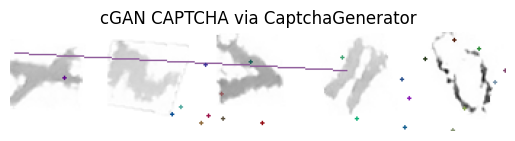

In [26]:
gen = CaptchaGenerator(mode="cgan", g_ckpt=str(best_ckpt))
img = gen.generate("X5vUa", save_path="samples/example_cgan.png")
show_image(img, "cGAN CAPTCHA via CaptchaGenerator")

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_26172\2233121261.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, mode="L").convert("RGBA")


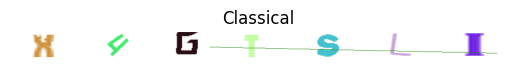

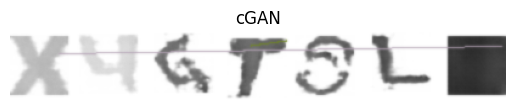

In [73]:
gen_classical = CaptchaGenerator(mode="classical")
gen_str = "x4GTsLI"
img1 = gen_classical.generate(gen_str, augment=False)
img2 = gen.generate(gen_str, augment=False)

show_image(img1, "Classical")
show_image(img2, "cGAN")



## 7. Notes
- If some classes are scarce, consider oversampling or weighted sampling during cGAN training.
- Increase `IMG_SIZE` to 64 and adjust conv stack for more detail.
- You can add elastic warps, shadows, curved baselines in the **whole-canvas** step.
- For fully end-to-end sequence generators (string→image), consider diffusion or transformer-based renderers later; 
  here we keep it robust and practical for your dataset.
